In [8]:
# --- Imports ---
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# If you like seaborn CM:
import seaborn as sns


In [9]:
# --- Config ---
BASE_DIR = "data/data"  # <- change if needed
cancer_types = [
    "Breast Invasive Carcinoma",
    "Kidney Renal Clear Cell Carcinoma",
    "Lung Adenocarcinoma",
    "Lung Squamous Cell Carcinoma",
    "Pancreatic Adenocarcinoma",
    "Uveal Melanoma",
]


In [10]:
# --- Load all files (your long-format loop) ---
all_data = []

for cancer in cancer_types:
    cancer_dir = os.path.join(BASE_DIR, cancer)
    for root, _, files in os.walk(cancer_dir):
        for file in files:
            if file.endswith(".mirbase21.mirnas.quantification.txt"):
                file_path = os.path.join(root, file)
                df = pd.read_csv(file_path, sep="\t")
                df = df[["miRNA_ID", "reads_per_million_miRNA_mapped"]]
                df["cancer_type"] = cancer
                df["file_id"] = os.path.basename(root)  # keep sample id
                all_data.append(df)

combined_df = pd.concat(all_data, ignore_index=True)
print(f"Total rows loaded: {len(combined_df)}")
print(combined_df.groupby("cancer_type")["file_id"].nunique())


Total rows loaded: 5445495
cancer_type
Breast Invasive Carcinoma            1096
Kidney Renal Clear Cell Carcinoma     544
Lung Adenocarcinoma                   519
Lung Squamous Cell Carcinoma          478
Pancreatic Adenocarcinoma             178
Uveal Melanoma                         80
Name: file_id, dtype: int64


In [11]:
# --- Pivot to wide matrix: rows = (file_id, cancer_type), cols = miRNA_ID ---
wide = (
    combined_df
    .pivot_table(index=["file_id", "cancer_type"],
                 columns="miRNA_ID",
                 values="reads_per_million_miRNA_mapped",
                 aggfunc="sum")
    .fillna(0.0)
    .astype(float)
    .sort_index(axis=1)
)

wide_df = wide.reset_index()
X = wide_df.drop(columns=["file_id", "cancer_type"])
y_text = wide_df["cancer_type"]

print("Shape:", X.shape, " Classes:", y_text.nunique())


Shape: (2895, 1881)  Classes: 6


In [12]:
# --- Encode labels & split ---
le = LabelEncoder()
y = le.fit_transform(y_text)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

num_classes = len(le.classes_)
input_dim = X.shape[1]
print("Input dim:", input_dim, "Num classes:", num_classes)


Input dim: 1881 Num classes: 6


In [13]:
# --- Build a scikit pipeline: Standardize -> MLPClassifier ---
# A small, sensible baseline: 2 hidden layers, ReLU, early stopping
mlp = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("clf", MLPClassifier(
        hidden_layer_sizes=(256, 128),
        activation="relu",
        solver="adam",
        alpha=1e-4,                 # L2 regularization
        learning_rate_init=1e-3,
        batch_size=32,
        max_iter=200,               # will usually stop earlier
        early_stopping=True,        # uses 10% of training as validation set
        n_iter_no_change=10,
        random_state=42,
        verbose=False
    ))
])

mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.3f}")

print(classification_report(y_test, y_pred, target_names=le.classes_))


Test Accuracy: 0.967
                                   precision    recall  f1-score   support

        Breast Invasive Carcinoma       0.98      0.99      0.99       219
Kidney Renal Clear Cell Carcinoma       1.00      0.97      0.99       109
              Lung Adenocarcinoma       0.95      0.92      0.94       104
     Lung Squamous Cell Carcinoma       0.91      0.96      0.93        96
        Pancreatic Adenocarcinoma       0.97      0.97      0.97        35
                   Uveal Melanoma       1.00      0.94      0.97        16

                         accuracy                           0.97       579
                        macro avg       0.97      0.96      0.96       579
                     weighted avg       0.97      0.97      0.97       579



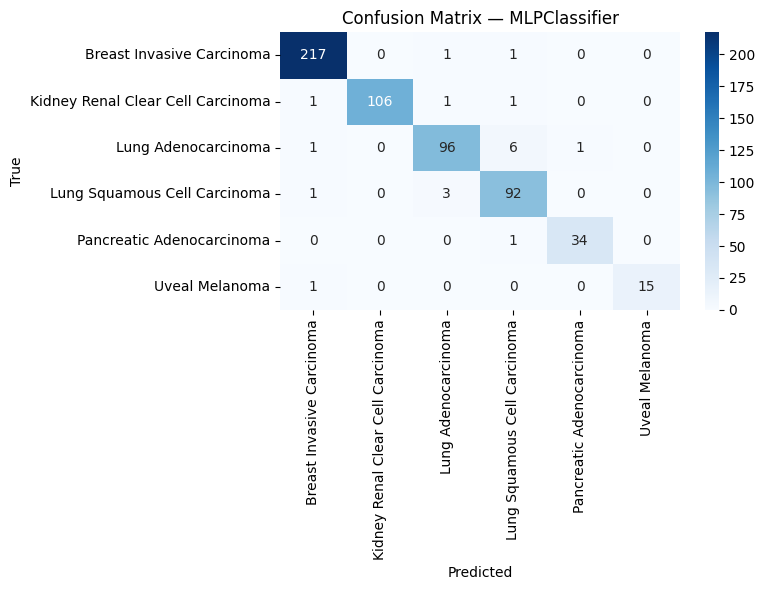

In [14]:
# --- Confusion matrix ---
labels = list(le.classes_)  # robust even if dtype changes later
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
if sns is not None:
    sns.heatmap(pd.DataFrame(cm, index=labels, columns=labels),
                annot=True, fmt="d", cmap="Blues")
else:
    plt.imshow(cm, cmap="Blues")
    plt.xticks(range(len(labels)), labels, rotation=45, ha="right")
    plt.yticks(range(len(labels)), labels)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i,j]), ha="center", va="center")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix — MLPClassifier")
plt.tight_layout()
plt.show()
